In [147]:
# Force install the compatible version of protobuf
!pip install "protobuf==3.20.3" --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [148]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/training-dataset/train.csv
/kaggle/input/signal-cluster-classification-dataset/sample_submission.csv.csv
/kaggle/input/signal-cluster-classification-dataset/train.csv
/kaggle/input/signal-cluster-classification-dataset/test.csv


In [149]:
# Load the data (if you haven't already)
df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/train.csv')

# Print column names so we can copy-paste them exactly
print(df.columns.tolist())

['sample_id', 'signal_strength', 'response_level', 'category']


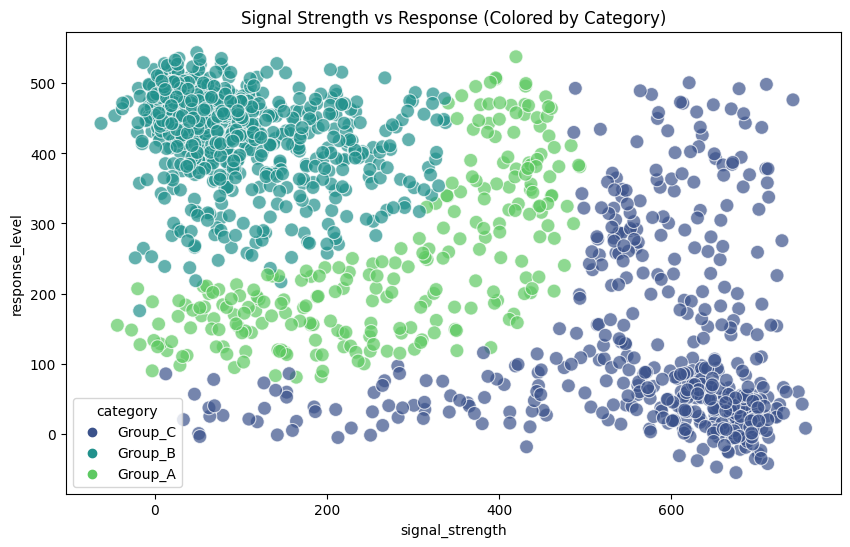

In [150]:


plt.figure(figsize=(10, 6))

# REPLACE 'signal_strength' and 'response_level' with the exact names found in Cell 1
sns.scatterplot(
    data=df, 
    x='signal_strength', 
    y='response_level', 
    hue='category',  # Colors the dots by Group_B, Group_C
    palette='viridis',
    s=100,           # Makes dots bigger
    alpha=0.7        # Makes dots slightly transparent
)

plt.title('Signal Strength vs Response (Colored by Category)')
plt.show()

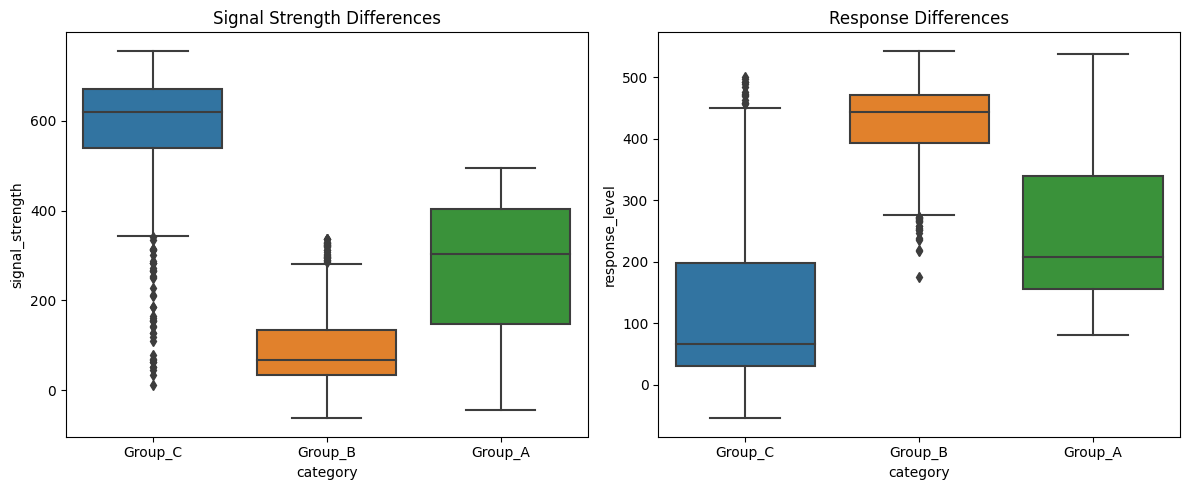

In [151]:
plt.figure(figsize=(12, 5))

# Plot 1: Signal Strength by Category
plt.subplot(1, 2, 1)
sns.boxplot(x='category', y='signal_strength', data=df)
plt.title('Signal Strength Differences')

# Plot 2: Response by Category
plt.subplot(1, 2, 2)
sns.boxplot(x='category', y='response_level', data=df)
plt.title('Response Differences')

plt.tight_layout()
plt.show()

In [152]:
# Create a clean dataframe for training
# axis=1 means we are dropping a column, not a row
df_clean = df.drop('sample_id', axis=1)

print("Columns remaining for training:")
print(df_clean.columns.tolist())

Columns remaining for training:
['signal_strength', 'response_level', 'category']


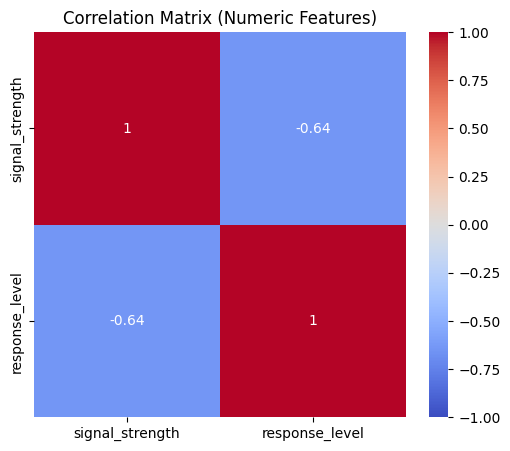

In [153]:

# Select only the numeric columns for correlation
numeric_cols = ['signal_strength', 'response_level']

# Calculate correlation
corr = df[numeric_cols].corr()

# Plot the Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

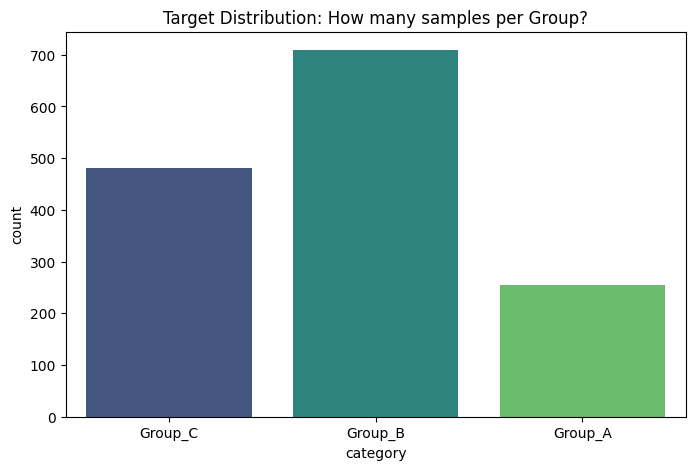

category
Group_B    709
Group_C    481
Group_A    254
Name: count, dtype: int64


In [154]:
plt.figure(figsize=(8, 5))
sns.countplot(x='category', data=df, palette='viridis')
plt.title('Target Distribution: How many samples per Group?')
plt.show()

# Print exact numbers
print(df['category'].value_counts())

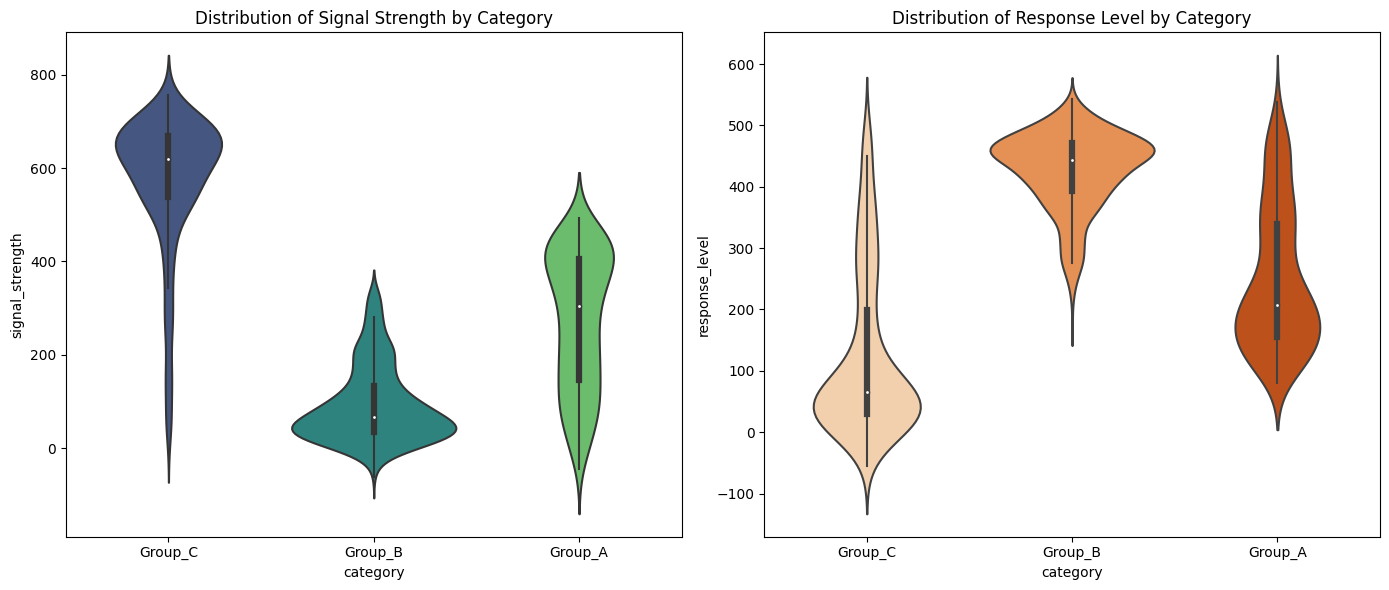

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Signal Strength Distribution
sns.violinplot(x='category', y='signal_strength', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Signal Strength by Category')

# Plot 2: Response Level Distribution
sns.violinplot(x='category', y='response_level', data=df, ax=axes[1], palette='Oranges')
axes[1].set_title('Distribution of Response Level by Category')

plt.tight_layout()
plt.show()

Fat part is where majority of data points are clustered, Thin part are outliers.
white dot is median

Left
This graph shows Signal Strength on the vertical axis.
Group_C (Blue): The "bulge" is very high up (around 600-700). This group has the Strongest Signal.
Group_A (Light Green): The bulge is in the middle (around 300-400). This group has Medium Signal.
Group_B (Dark Teal): The bulge is low (around 100). This group has the Weakest Signal.
Key Insight: Signal Strength creates a "staircase." It separates the three groups almost perfectly by itself.

Right
This graph shows Response Level on the vertical axis.
Group_B (Orange): The bulge is high (around 450).
Group_A (Red/Brown): The bulge is in the middle/low-middle.
Group_C (Beige): The bulge is very low (around 50-100).
Key Insight: This is the exact opposite of the first graph. The group with the lowest signal (Group B) has the highest response.

In [156]:
# Initialize the encoder
le = LabelEncoder()

# Fit and transform the 'category' column
# We create a new column 'target_encoded' so we don't lose the original text yet
df['target_encoded'] = le.fit_transform(df['category'])

# Verify the mapping (See what number represents what group)
print("Class Mapping:")
for i, label in enumerate(le.classes_):
    print(f"{label}  ->  {i}")

# Show the first few rows to see the new column
df.head()

Class Mapping:
Group_A  ->  0
Group_B  ->  1
Group_C  ->  2


,sample_id,signal_strength,response_level,category,target_encoded
0,901,722.566585,153.933763,Group_C,2
1,1799,210.432525,454.613761,Group_B,1
2,1129,152.569777,431.993189,Group_B,1
3,965,670.294068,-6.559720,Group_C,2
4,395,49.418875,444.775273,Group_B,1


In [157]:
# 1. Select the features we want to train on (IGNORING sample_id)
feature_cols = ['signal_strength', 'response_level']

X = df[feature_cols]  # This creates a table with ONLY these two columns
y = df['target_encoded'] # This is our target (0, 1, 2)

# Verify X does not have sample_id
print("Training Features:")
print(X.head())

Training Features:
   signal_strength  response_level
0       722.566585      153.933763
1       210.432525      454.613761
2       152.569777      431.993189
3       670.294068       -6.559720
4        49.418875      444.775273


In [158]:
# split the data (80% train, 20% test)
# random_state=42 ensures we get the same split every time we run it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1155, 2)
Testing shape: (289, 2)


In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Initialize the model
# n_estimators=100 means we use 100 different decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model on the 80% training data
rf_model.fit(X_train, y_train)

# 3. Make predictions on the 20% testing data
y_pred = rf_model.predict(X_test)

print("Model Trained Successfully!")

Model Trained Successfully!


Running random forest first

In [160]:
# Calculate simple accuracy (0 to 1)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

print("\n--- Detailed Report ---")
# target_names helps us read the report with the original text labels
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 99.31%

--- Detailed Report ---
              precision    recall  f1-score   support

     Group_A       1.00      0.97      0.98        61
     Group_B       0.99      1.00      1.00       141
     Group_C       0.99      1.00      0.99        87

    accuracy                           0.99       289
   macro avg       0.99      0.99      0.99       289
weighted avg       0.99      0.99      0.99       289



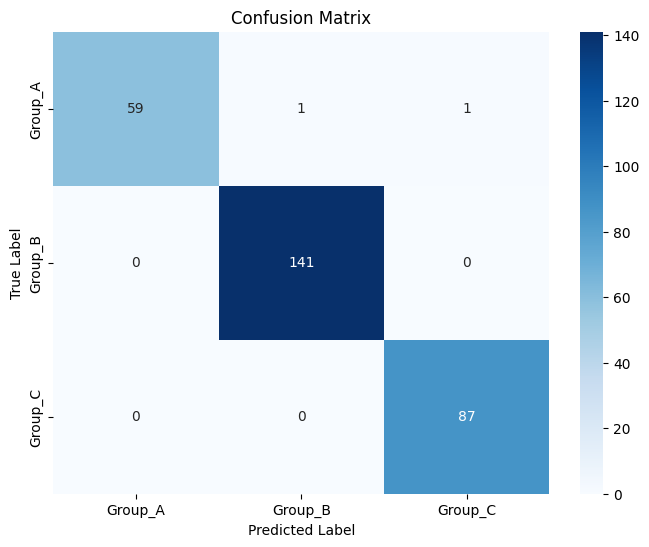

In [161]:
from sklearn.metrics import confusion_matrix

# Generate the matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [162]:
# 1. Get predictions on the Training Set (the data the model learned from)
train_preds = rf_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

# 2. Get predictions on the Test Set (the new data, acting as validation)
val_preds = rf_model.predict(X_test)
val_acc = accuracy_score(y_test, val_preds)

# 3. Print the comparison
print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# 4. Check for Overfitting
if train_acc > val_acc + 0.05:
    print("\nWarning: Potential Overfitting (Train score is much higher than Validation)")
else:
    print("\nGreat! The model generalizes well (Scores are close).")

Training Accuracy:   100.00%
Validation Accuracy: 99.31%

Great! The model generalizes well (Scores are close).


In [163]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross Validation
# This splits the data into 5 parts and tests the model 5 times
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print("--- Cross-Validation Results ---")
print(f"Scores for each run: {cv_scores}")
print(f"Average Accuracy:    {cv_scores.mean() * 100:.2f}%")

--- Cross-Validation Results ---
Scores for each run: [0.98269896 0.98615917 0.99653979 0.99307958 0.98263889]
Average Accuracy:    98.82%


In [164]:
import joblib

# Save the Random Forest model we trained earlier
joblib.dump(rf_model, 'my_random_forest.joblib')

# Save the Label Encoder too! 
# (We need this to turn predictions like 0, 1, 2 back into "Group_A")
joblib.dump(le, 'my_label_encoder.joblib')

print("Model and Encoder saved!")

Model and Encoder saved!


In [165]:
# 1. Load the test data
test_df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/test.csv')

# 2. Separate the ID column (we need it for the final submission file)
test_ids = test_df['sample_id']

# 3. Create the input data (X_new)
# We must DROP sample_id because the model wasn't trained on it
X_new = test_df.drop('sample_id', axis=1)

# Verify columns match exactly what we trained on
print("Training columns were: ['signal_strength', 'response_level']")
print(f"Testing columns are:   {X_new.columns.tolist()}")

Training columns were: ['signal_strength', 'response_level']
Testing columns are:   ['signal_strength', 'response_level']


In [166]:
# 1. Load the model from the file (just to show how it works)
loaded_model = joblib.load('my_random_forest.joblib')
loaded_le = joblib.load('my_label_encoder.joblib')

# 2. Make predictions (This gives numbers: 0, 1, 2)
numeric_predictions = loaded_model.predict(X_new)

# 3. Convert numbers back to text (0 -> "Group_A")
text_predictions = loaded_le.inverse_transform(numeric_predictions)

print("First 5 predictions:")
print(text_predictions[:5])

First 5 predictions:
['Group_C' 'Group_C' 'Group_B' 'Group_A' 'Group_C']


In [167]:
# Create a new DataFrame for submission
submission = pd.DataFrame({
    'sample_id': test_ids,
    'category': text_predictions
})

# Save it to disk
submission.to_csv('random_submission.csv', index=False)

print("random_submission.csv saved! You can now download it or submit it.")
print(submission.head())

random_submission.csv saved! You can now download it or submit it.
   sample_id category
0       1369  Group_C
1         66  Group_C
2        701  Group_B
3        939  Group_A
4       1622  Group_C


In [168]:
from sklearn.metrics import accuracy_score, f1_score

def print_error_report(model, X_train, y_train, X_test, y_test, model_name):
    # 1. Predict on Training Data
    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    train_err = 1.0 - train_acc
    # Calculate F1 for Train (Weighted for multi-class)
    train_f1 = f1_score(y_train, train_preds, average='weighted')
    
    # 2. Predict on Test Data
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    test_err = 1.0 - test_acc
    # Calculate F1 for Test
    test_f1 = f1_score(y_test, test_preds, average='weighted')
    
    # 3. Print Report
    print(f"--- {model_name} Report ---")
    print(f"Train Accuracy: {train_acc*100:.2f}% | Error: {train_err*100:.2f}% | F1: {train_f1:.4f}")
    print(f"Test  Accuracy: {test_acc*100:.2f}% | Error: {test_err*100:.2f}% | F1: {test_f1:.4f}")
    
    # Check for Overfitting
    if train_acc - test_acc > 0.05:
        print("⚠️ Warning: High Overfitting (Model is memorizing, not learning)")
    elif test_acc > train_acc:
        print("✅ Good Generalization (Test score is excellent)")
    else:
        print("✅ Good Balance")
    print("-" * 30)

In [169]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Initialize
# We use probability=True so we can use it for advanced graphs later if needed
svm_model = SVC(kernel='rbf', random_state=42, probability=True)

# 2. Train
svm_model.fit(X_train, y_train)

# 3. Evaluate using our new function
print_error_report(svm_model, X_train, y_train, X_test, y_test, "SVM (RBF Kernel)")

--- SVM (RBF Kernel) Report ---
Train Accuracy: 98.87% | Error: 1.13% | F1: 0.9888
Test  Accuracy: 98.27% | Error: 1.73% | F1: 0.9829
✅ Good Balance
------------------------------


In [170]:
# Calculate Accuracy
svm_acc = accuracy_score(y_test, svm_preds)
print(f"SVM Accuracy: {svm_acc * 100:.2f}%")

print("\n--- Detailed Report ---")
print(classification_report(y_test, svm_preds, target_names=le.classes_))

SVM Accuracy: 98.27%

--- Detailed Report ---
              precision    recall  f1-score   support

     Group_A       0.94      0.98      0.96        61
     Group_B       1.00      0.99      0.99       141
     Group_C       0.99      0.98      0.98        87

    accuracy                           0.98       289
   macro avg       0.98      0.98      0.98       289
weighted avg       0.98      0.98      0.98       289



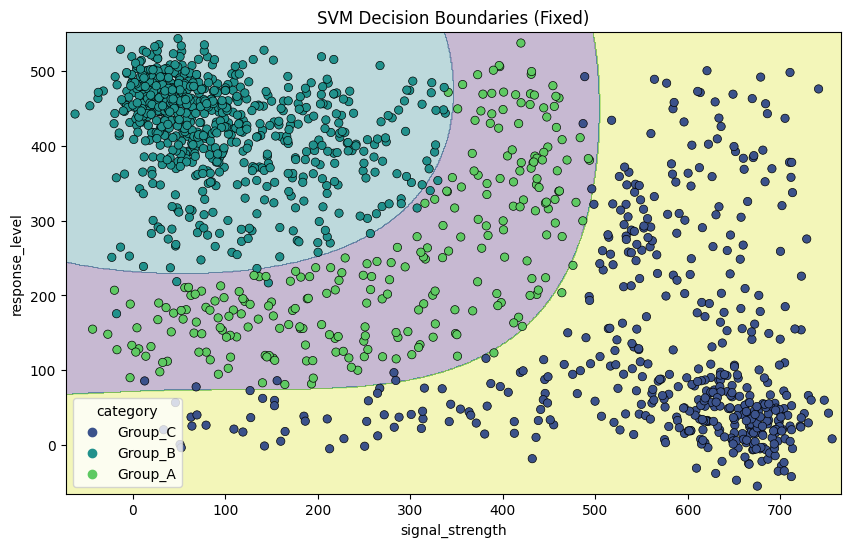

In [171]:
import numpy as np
import pandas as pd


# 1. Create the grid
x_min, x_max = X['signal_strength'].min() - 10, X['signal_strength'].max() + 10
y_min, y_max = X['response_level'].min() - 10, X['response_level'].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1.0),
                     np.arange(y_min, y_max, 1.0))

# 2. Prepare the input as a DataFrame (Fixes the Warning!)
# We use the exact same column names the model was trained on
grid_data = pd.DataFrame(
    np.c_[xx.ravel(), yy.ravel()], 
    columns=['signal_strength', 'response_level']
)

# 3. Predict
Z = svm_model.predict(grid_data)
Z = Z.reshape(xx.shape)

# 4. Plot
plt.figure(figsize=(10, 6))
# The contourf draws the colored background regions
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
# The scatter draws your actual data points
sns.scatterplot(
    x='signal_strength', 
    y='response_level', 
    hue='category', 
    data=df, 
    palette='viridis', 
    edgecolor='k'
)
plt.title('SVM Decision Boundaries (Fixed)')
plt.show()

In [172]:
import joblib

joblib.dump(best_svm_fe, 'raw_svm_model.joblib')

# Just in case, let's verify it's there
import os
print("Files in your output directory:")
print(os.listdir('/kaggle/working'))

# 1. Load the raw test data
test_df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/test.csv')
submission_ids = test_df['sample_id']

# 2. Prepare the input columns (Drop ID)
X_submission_raw = test_df.drop('sample_id', axis=1)

# 3. CRITICAL STEP: Apply the same Feature Engineering to the test data
# The model expects 'interaction' and 'sig_diff' to exist!
X_submission_fe = create_features(X_submission_raw)

print("Columns prepared for model:", X_submission_fe.columns.tolist())

# 4. Predict using the BEST Tuned SVM (best_svm_fe)
# The pipeline inside will handle the scaling automatically
numeric_preds = best_svm_fe.predict(X_submission_fe)

# 5. Convert numbers back to text
text_preds = le.inverse_transform(numeric_preds)

# 6. Save the Champion Submission
submission = pd.DataFrame({
    'sample_id': submission_ids,
    'category': text_preds
})

submission.to_csv('raw_svm(2).csv', index=False)

print("✅ Champion file saved: raw_svm(2).csv")
print(submission.head())

Files in your output directory:
['champion_svm_model.joblib', 'submission_svm_normalized_only.csv', 'logreg_fe_model.joblib', 'submission_logreg_fe.csv', 'logreg_raw_model.joblib', 'logreg_normalized_model.joblib', 'raw_svm_model.joblib', 'svm_normalized_model.joblib', 'my_label_encoder.joblib', '.virtual_documents', 'random_submission.csv', 'my_random_forest.joblib', 'submission_logreg_raw.csv', 'raw_svm(2).csv', 'submission_champion_svm(1).csv', 'submission_logreg_normalized.csv', 'submission_champion_svm(2).csv']
Columns prepared for model: ['signal_strength', 'response_level', 'interaction', 'sig_diff']
✅ Champion file saved: raw_svm(2).csv
   sample_id category
0       1369  Group_C
1         66  Group_C
2        701  Group_B
3        939  Group_A
4       1622  Group_C


In [173]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# 1. Create a Pipeline
# A pipeline ensures we scale the data first, THEN run the SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Step 1: Scale data
    ('svm', SVC(random_state=42))       # Step 2: The Model
])

# 2. Define the "Grid" of settings to test
# We will test 3 x 3 = 9 different combinations
param_grid = {
    'svm__C': [0.1, 1, 10, 100],        # strictness
    'svm__gamma': [1, 0.1, 0.01, 0.001], # reach
    'svm__kernel': ['rbf']              # keep using the curve kernel
}

# 3. Setup the Grid Search
# verbose=2 will print progress as it checks options
grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# 4. Train (This might take a few seconds as it trains 45+ models!)
print("Tuning model parameters...")
grid.fit(X_train, y_train)

# 5. Get the Best Results
print(f"\nBest Parameters Found: {grid.best_params_}")
print(f"Best Cross-Val Accuracy: {grid.best_score_ * 100:.2f}%")

# 6. Evaluate the Winner on the Test Set
best_model = grid.best_estimator_
print_error_report(best_model, X_train, y_train, X_test, y_test, "Tuned SVM")

Tuning model parameters...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters Found: {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best Cross-Val Accuracy: 98.96%
--- Tuned SVM Report ---
Train Accuracy: 98.87% | Error: 1.13% | F1: 0.9888
Test  Accuracy: 99.31% | Error: 0.69% | F1: 0.9931
✅ Good Generalization (Test score is excellent)
------------------------------


this normalises the signal strength as it ranges from 0 -800 while response only from 0 - 1, so svm think signal strenght is more important but if we normalise it we may getter better results

In [174]:
import joblib

# 'best_model' is the variable name from your Grid Search (the one without feature engineering)
joblib.dump(best_model, 'svm_normalized_model.joblib')

print("✅ Model saved: svm_normalized_model.joblib")

✅ Model saved: svm_normalized_model.joblib


In [175]:
# 1. Load the raw test data
test_df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/test.csv')

# 2. Separate ID and Features
submission_ids = test_df['sample_id']

# We DROP sample_id, but we do NOT run 'create_features' 
# because this model was trained on the original 2 columns only.
X_submission_norm = test_df.drop('sample_id', axis=1)

print("Columns prepared for model:", X_submission_norm.columns.tolist())

# 3. Predict using the 'best_model' from your Grid Search
# The Pipeline inside will automatically scale the data for you!
numeric_preds = best_model.predict(X_submission_norm)

# 4. Convert numbers back to text (0 -> Group_A)
text_preds = le.inverse_transform(numeric_preds)

# 5. Save the file with a specific name so you don't overwrite others
submission = pd.DataFrame({
    'sample_id': submission_ids,
    'category': text_preds
})

submission.to_csv('submission_svm_normalized_only.csv', index=False)

print("✅ File saved: submission_svm_normalized_only.csv")
print(submission.head())

Columns prepared for model: ['signal_strength', 'response_level']
✅ File saved: submission_svm_normalized_only.csv
   sample_id category
0       1369  Group_C
1         66  Group_C
2        701  Group_B
3        939  Group_A
4       1622  Group_C


In [176]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# --- 1. Define the Feature Engineering Function ---
def create_features(df):
    # Create a copy so we don't modify the original data
    df_fe = df.copy()
    
    # Feature A: Interaction (Signal * Response)
    # Good for capturing the "volume" or combined intensity
    df_fe['interaction'] = df_fe['signal_strength'] * df_fe['response_level']
    
    # Feature B: Difference (Signal - Response)
    # Good for distinguishing cases where one value is much higher than the other
    df_fe['sig_diff'] = df_fe['signal_strength'] - df_fe['response_level']
    
    return df_fe

# --- 2. Apply it to your Training and Test data ---
# This creates the variables X_train_fe and X_test_fe that you were missing
X_train_fe = create_features(X_train)
X_test_fe = create_features(X_test)

print("Feature Engineering Complete.")
print(f"New shape: {X_train_fe.shape} (Should have 4 columns)")

# --- 3. Create the Pipeline (Scale -> Train SVM) ---
svm_fe_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Crucial: Squashes that huge 'interaction' value down
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', random_state=42)) 
])

# --- 4. Train on the new data ---
svm_fe_pipeline.fit(X_train_fe, y_train)

# --- 5. Evaluate ---
print("\n--- SVM with Feature Engineering Results ---")
# Using the error report function we defined earlier
print_error_report(svm_fe_pipeline, X_train_fe, y_train, X_test_fe, y_test, "SVM + FE")

Feature Engineering Complete.
New shape: (1155, 4) (Should have 4 columns)

--- SVM with Feature Engineering Results ---
--- SVM + FE Report ---
Train Accuracy: 99.13% | Error: 0.87% | F1: 0.9914
Test  Accuracy: 98.96% | Error: 1.04% | F1: 0.9896
✅ Good Balance
------------------------------


In [177]:
# Define grid for the new features
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.1, 0.01],
}

# Run Grid Search
grid_fe = GridSearchCV(svm_fe_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_fe.fit(X_train_fe, y_train)

print(f"Best Params for FE data: {grid_fe.best_params_}")

# Evaluate the tuned model
best_svm_fe = grid_fe.best_estimator_
print_error_report(best_svm_fe, X_train_fe, y_train, X_test_fe, y_test, "Tuned SVM + FE")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params for FE data: {'svm__C': 1, 'svm__gamma': 'scale'}
--- Tuned SVM + FE Report ---
Train Accuracy: 99.05% | Error: 0.95% | F1: 0.9906
Test  Accuracy: 99.65% | Error: 0.35% | F1: 0.9965
✅ Good Generalization (Test score is excellent)
------------------------------


In [178]:
import joblib

# Save the Best Tuned SVM (which includes the scaling pipeline)
# We call it 'champion' so you know it's the best one
joblib.dump(best_svm_fe, 'champion_svm_model.joblib')

# Just in case, let's verify it's there
import os
print("Files in your output directory:")
print(os.listdir('/kaggle/working'))

Files in your output directory:
['champion_svm_model.joblib', 'submission_svm_normalized_only.csv', 'logreg_fe_model.joblib', 'submission_logreg_fe.csv', 'logreg_raw_model.joblib', 'logreg_normalized_model.joblib', 'raw_svm_model.joblib', 'svm_normalized_model.joblib', 'my_label_encoder.joblib', '.virtual_documents', 'random_submission.csv', 'my_random_forest.joblib', 'submission_logreg_raw.csv', 'raw_svm(2).csv', 'submission_champion_svm(1).csv', 'submission_logreg_normalized.csv', 'submission_champion_svm(2).csv']


In [179]:
# 1. Load the raw test data
test_df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/test.csv')
submission_ids = test_df['sample_id']

# 2. Prepare the input columns (Drop ID)
X_submission_raw = test_df.drop('sample_id', axis=1)

# 3. CRITICAL STEP: Apply the same Feature Engineering to the test data
# The model expects 'interaction' and 'sig_diff' to exist!
X_submission_fe = create_features(X_submission_raw)

print("Columns prepared for model:", X_submission_fe.columns.tolist())

# 4. Predict using the BEST Tuned SVM (best_svm_fe)
# The pipeline inside will handle the scaling automatically
numeric_preds = best_svm_fe.predict(X_submission_fe)

# 5. Convert numbers back to text
text_preds = le.inverse_transform(numeric_preds)

# 6. Save the Champion Submission
submission = pd.DataFrame({
    'sample_id': submission_ids,
    'category': text_preds
})

submission.to_csv('submission_champion_svm(2).csv', index=False)

print("✅ Champion file saved: submission_champion_svm(2).csv")
print(submission.head())

Columns prepared for model: ['signal_strength', 'response_level', 'interaction', 'sig_diff']
✅ Champion file saved: submission_champion_svm(2).csv
   sample_id category
0       1369  Group_C
1         66  Group_C
2        701  Group_B
3        939  Group_A
4       1622  Group_C


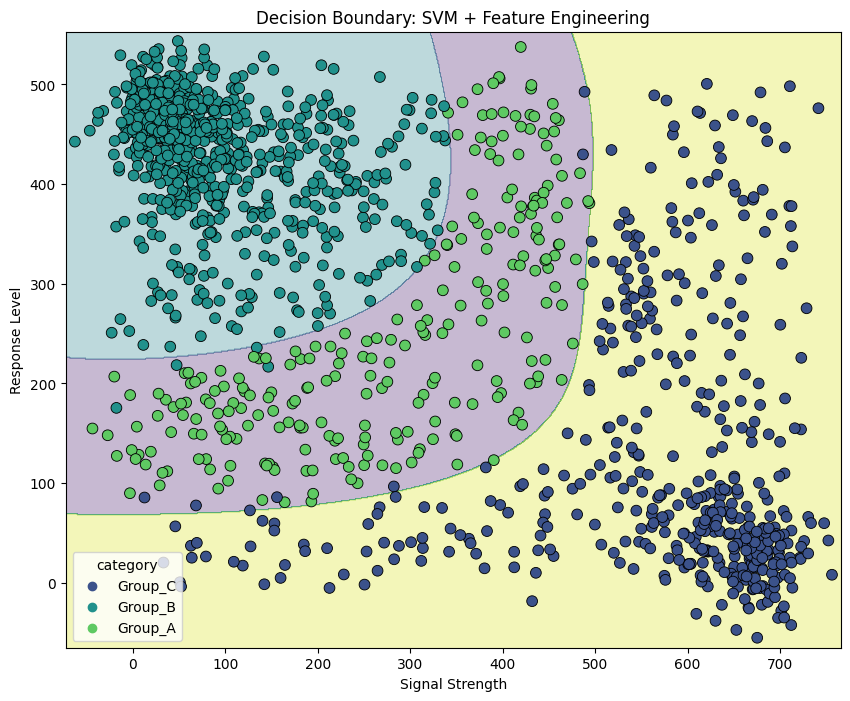

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the Grid (Same as before)
# We strictly define the range based on Signal and Response
x_min, x_max = X['signal_strength'].min() - 10, X['signal_strength'].max() + 10
y_min, y_max = X['response_level'].min() - 10, X['response_level'].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1.0),
                     np.arange(y_min, y_max, 1.0))

# 2. Create the Base DataFrame
grid_data = pd.DataFrame(
    np.c_[xx.ravel(), yy.ravel()], 
    columns=['signal_strength', 'response_level']
)

# 3. CRITICAL STEP: Apply Feature Engineering to the Grid
# The model needs 'interaction' and 'sig_diff' to make a decision.
# We reuse your function to calculate them for the virtual grid points.
grid_fe = create_features(grid_data)

# 4. Predict using the Champion Model (best_svm_fe)
# The pipeline inside handles the Scaling, so we don't need to do it manually here.
Z = best_svm_fe.predict(grid_fe)
Z = Z.reshape(xx.shape)

# 5. Plot
plt.figure(figsize=(10, 8))

# Draw the complex boundaries
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Draw the original data points
sns.scatterplot(
    x='signal_strength', 
    y='response_level', 
    hue='category', 
    data=df, 
    palette='viridis', 
    edgecolor='k',
    s=60
)

plt.title('Decision Boundary: SVM + Feature Engineering')
plt.xlabel('Signal Strength')
plt.ylabel('Response Level')
plt.show()

In [181]:
from sklearn.linear_model import LogisticRegression
import joblib

# 1. Train Raw Model
# We increase max_iter to 2000 because raw data makes the model learn very slowly
logreg_raw = LogisticRegression(random_state=42, max_iter=2000)
logreg_raw.fit(X_train, y_train)

# 2. Evaluate
print_error_report(logreg_raw, X_train, y_train, X_test, y_test, "Logistic Regression (Raw)")

# 3. Save Model
joblib.dump(logreg_raw, 'logreg_raw_model.joblib')

# 4. Generate Submission
test_df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/test.csv')
submission_ids = test_df['sample_id']
X_sub_raw = test_df.drop('sample_id', axis=1)

raw_preds = logreg_raw.predict(X_sub_raw)
submission_raw = pd.DataFrame({'sample_id': submission_ids, 'category': le.inverse_transform(raw_preds)})
submission_raw.to_csv('submission_logreg_raw.csv', index=False)
print("✅ Saved: submission_logreg_raw.csv")

--- Logistic Regression (Raw) Report ---
Train Accuracy: 92.29% | Error: 7.71% | F1: 0.9232
Test  Accuracy: 89.27% | Error: 10.73% | F1: 0.8928
✅ Good Balance
------------------------------
✅ Saved: submission_logreg_raw.csv


In [182]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. Train Normalized Model (Pipeline)
logreg_norm_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=42))
])
logreg_norm_pipe.fit(X_train, y_train)

# 2. Evaluate
print_error_report(logreg_norm_pipe, X_train, y_train, X_test, y_test, "Logistic Regression (Normalized)")

# 3. Save Model
joblib.dump(logreg_norm_pipe, 'logreg_normalized_model.joblib')

# 4. Generate Submission
# Pipeline handles scaling automatically!
norm_preds = logreg_norm_pipe.predict(X_sub_raw) 
submission_norm = pd.DataFrame({'sample_id': submission_ids, 'category': le.inverse_transform(norm_preds)})
submission_norm.to_csv('submission_logreg_normalized.csv', index=False)
print("✅ Saved: submission_logreg_normalized.csv")

--- Logistic Regression (Normalized) Report ---
Train Accuracy: 92.47% | Error: 7.53% | F1: 0.9250
Test  Accuracy: 89.62% | Error: 10.38% | F1: 0.8952
✅ Good Balance
------------------------------
✅ Saved: submission_logreg_normalized.csv


In [183]:
# 1. Train on Feature Engineered Data (X_train_fe)
# We MUST scale here because 'interaction' values are huge (200,000+)
logreg_fe_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=42))
])
logreg_fe_pipe.fit(X_train_fe, y_train)

# 2. Evaluate
print_error_report(logreg_fe_pipe, X_train_fe, y_train, X_test_fe, y_test, "Logistic Regression (Feature Eng)")

# 3. Save Model
joblib.dump(logreg_fe_pipe, 'logreg_fe_model.joblib')

# 4. Generate Submission
# CRITICAL: We must create features for the test set first
X_sub_fe = create_features(X_sub_raw) 

fe_preds = logreg_fe_pipe.predict(X_sub_fe)
submission_fe = pd.DataFrame({'sample_id': submission_ids, 'category': le.inverse_transform(fe_preds)})
submission_fe.to_csv('submission_logreg_fe.csv', index=False)
print("✅ Saved: submission_logreg_fe.csv")

--- Logistic Regression (Feature Eng) Report ---
Train Accuracy: 95.24% | Error: 4.76% | F1: 0.9525
Test  Accuracy: 94.12% | Error: 5.88% | F1: 0.9418
✅ Good Balance
------------------------------
✅ Saved: submission_logreg_fe.csv


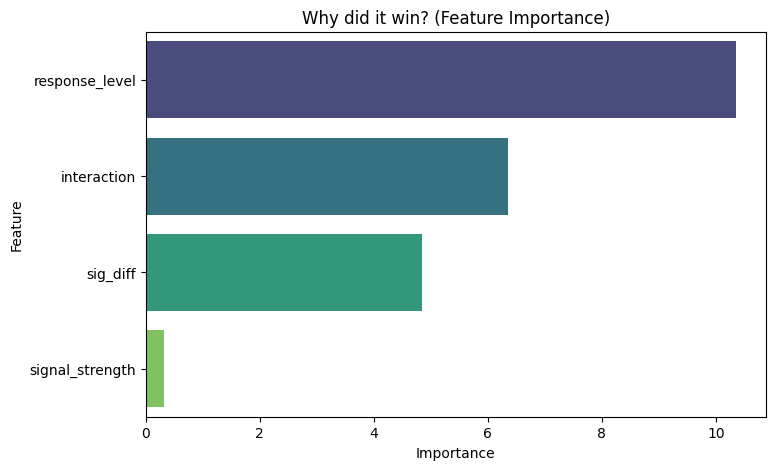

In [184]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Access the classifier inside the pipeline
# We use .named_steps['logreg'] because we used a Pipeline
model = logreg_fe_pipe.named_steps['logreg']

# 2. Get the coefficients (The "Vote Power" of each feature)
# Since you have 3 classes (A, B, C), there are 3 sets of coefficients.
# We will look at the average absolute importance across all classes.
coeffs = pd.DataFrame({
    'Feature': X_train_fe.columns,
    'Importance': abs(model.coef_[0]) + abs(model.coef_[1]) + abs(model.coef_[2]) 
})

# 3. Sort by importance
coeffs = coeffs.sort_values(by='Importance', ascending=False)

# 4. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=coeffs, palette='viridis')
plt.title('Why did it win? (Feature Importance)')
plt.show()

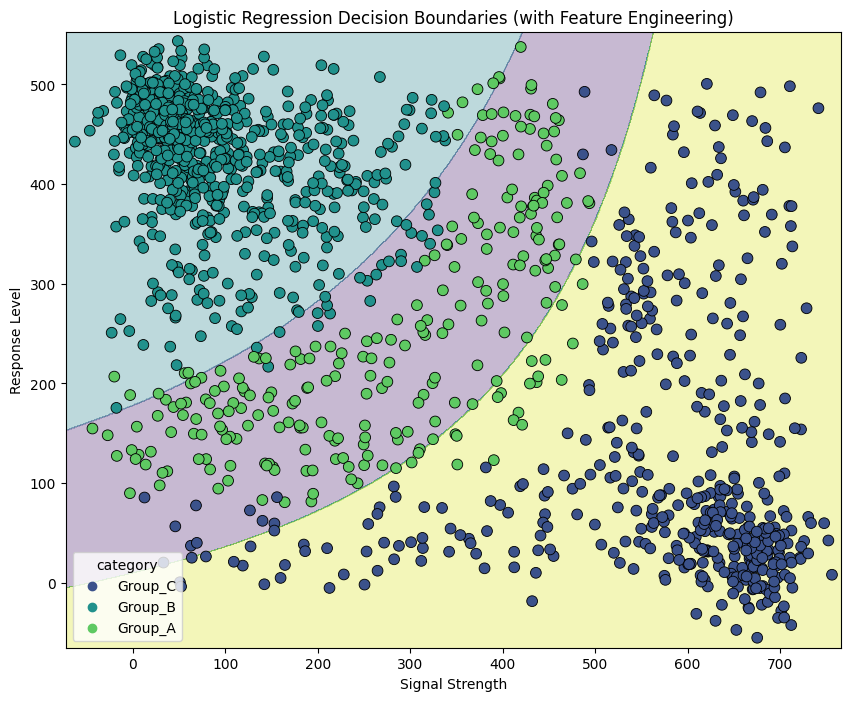

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the Grid (The "Canvas")
x_min, x_max = X['signal_strength'].min() - 10, X['signal_strength'].max() + 10
y_min, y_max = X['response_level'].min() - 10, X['response_level'].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1.0),
                     np.arange(y_min, y_max, 1.0))

# 2. Create the Base DataFrame for the Grid
grid_data = pd.DataFrame(
    np.c_[xx.ravel(), yy.ravel()], 
    columns=['signal_strength', 'response_level']
)

# 3. CRITICAL: Apply Feature Engineering to the Grid
# The Logistic Regression expects 'interaction' and 'sig_diff' columns!
grid_fe = create_features(grid_data)

# 4. Predict using the Feature Engineered Pipeline
# We use the pipeline variable 'logreg_fe_pipe' from the previous step
Z = logreg_fe_pipe.predict(grid_fe)
Z = Z.reshape(xx.shape)

# 5. Plot
plt.figure(figsize=(10, 8))

# Draw the colored regions (The Decision Boundaries)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Draw the actual data points
sns.scatterplot(
    x='signal_strength', 
    y='response_level', 
    hue='category', 
    data=df, 
    palette='viridis', 
    edgecolor='k',
    s=60
)

plt.title('Logistic Regression Decision Boundaries (with Feature Engineering)')
plt.xlabel('Signal Strength')
plt.ylabel('Response Level')
plt.show()

In [186]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Set seed for reproducibility
tf.random.set_seed(42)

def build_neural_net(input_shape):
    model = keras.Sequential([
        # Layer 1: The Input
        layers.Input(shape=(input_shape,)),
        
        # Layer 2: Hidden Layer (64 Neurons, ReLU activation)
        # ReLU allows the model to learn non-linear patterns (curves)
        layers.Dense(64, activation='relu'),
        
        # Layer 3: Second Hidden Layer (32 Neurons)
        layers.Dense(32, activation='relu'),
        
        # Layer 4: Output Layer (3 Neurons = 3 Classes)
        # Softmax turns the output into probabilities (e.g., [0.1, 0.8, 0.1])
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # Used for integers (0, 1, 2)
        metrics=['accuracy']
    )
    return model

In [187]:
print("--- Training Model A: Raw Data ---")
# Input shape is 2 (signal, response)
nn_raw = build_neural_net(2) 

history_raw = nn_raw.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=16,
    verbose=0 # Silence the output
)

# Convert probabilities to class labels (0, 1, 2)
raw_probs = nn_raw.predict(X_test)
raw_preds = np.argmax(raw_probs, axis=1) # Pick the highest probability

# Standard Report (We create a dummy class to trick our report function)
class KerasWrapper:
    def predict(self, X): return np.argmax(nn_raw.predict(X), axis=1)

print_error_report(KerasWrapper(), X_train, y_train, X_test, y_test, "NN Raw")

--- Training Model A: Raw Data ---


2025-11-27 14:06:54.411044: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- NN Raw Report ---
Train Accuracy: 89.78% | Error: 10.22% | F1: 0.8867
Test  Accuracy: 87.89% | Error: 12.11% | F1: 0.8653
✅ Good Balance
------------------------------


In [188]:
print("--- Training Model B: Normalized ---")
# We use the Scaler we created earlier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_norm = build_neural_net(2)

history_norm = nn_norm.fit(
    X_train_scaled, y_train,
    epochs=50, 
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    verbose=0
)

# Wrapper for report
class KerasWrapperNorm:
    def predict(self, X): return np.argmax(nn_norm.predict(X), axis=1)

print_error_report(KerasWrapperNorm(), X_train_scaled, y_train, X_test_scaled, y_test, "NN Normalized")

--- Training Model B: Normalized ---
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--- NN Normalized Report ---
Train Accuracy: 99.13% | Error: 0.87% | F1: 0.9913
Test  Accuracy: 98.62% | Error: 1.38% | F1: 0.9861
✅ Good Balance
------------------------------


In [189]:
print("--- Training Model C: Feature Engineered ---")
# Input shape is 4 (signal, response, interaction, diff)
scaler_fe = StandardScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
X_test_fe_scaled = scaler_fe.transform(X_test_fe)

nn_fe = build_neural_net(4) # Input shape is now 4!

history_fe = nn_fe.fit(
    X_train_fe_scaled, y_train,
    epochs=50, 
    batch_size=16,
    validation_data=(X_test_fe_scaled, y_test),
    verbose=0
)

# Wrapper for report
class KerasWrapperFE:
    def predict(self, X): return np.argmax(nn_fe.predict(X), axis=1)

print_error_report(KerasWrapperFE(), X_train_fe_scaled, y_train, X_test_fe_scaled, y_test, "NN Feature Eng")

--- Training Model C: Feature Engineered ---
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- NN Feature Eng Report ---
Train Accuracy: 99.22% | Error: 0.78% | F1: 0.9922
Test  Accuracy: 98.27% | Error: 1.73% | F1: 0.9826
✅ Good Balance
------------------------------


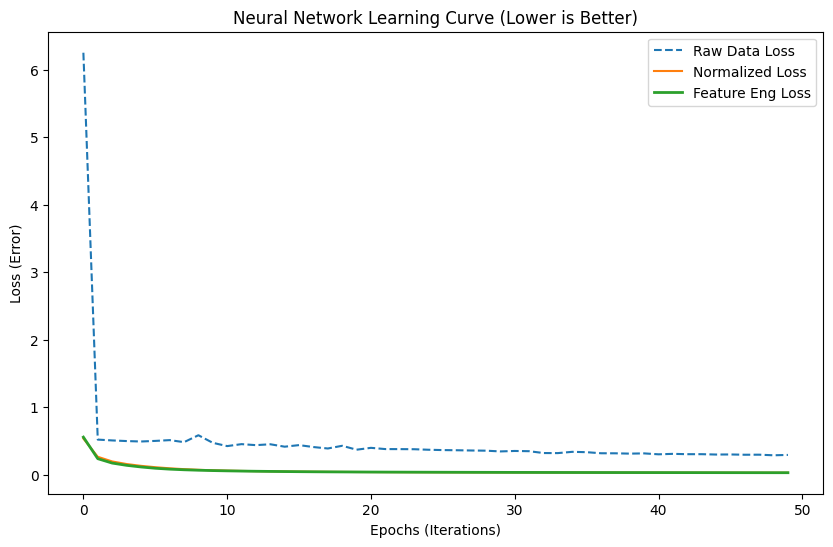

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_raw.history['loss'], label='Raw Data Loss', linestyle='--')
plt.plot(history_norm.history['loss'], label='Normalized Loss')
plt.plot(history_fe.history['loss'], label='Feature Eng Loss', linewidth=2)

plt.title('Neural Network Learning Curve (Lower is Better)')
plt.xlabel('Epochs (Iterations)')
plt.ylabel('Loss (Error)')
plt.legend()
plt.show()

In [191]:
import os

# 1. Save the Raw Model
nn_raw.save('nn_raw_model.keras')
print("✅ Saved: nn_raw_model.keras")

# 2. Save the Normalized Model
nn_norm.save('nn_normalized_model.keras')
print("✅ Saved: nn_normalized_model.keras")

# 3. Save the Feature Engineered Model (Champion Candidate)
nn_fe.save('nn_feature_engineered_model.keras')
print("✅ Saved: nn_feature_engineered_model.keras")

# 4. Verify they are in the folder
print("\nCurrent files in output directory:")
print(os.listdir('/kaggle/working'))

✅ Saved: nn_raw_model.keras
✅ Saved: nn_normalized_model.keras
✅ Saved: nn_feature_engineered_model.keras

Current files in output directory:
['champion_svm_model.joblib', 'nn_feature_engineered_model.keras', 'submission_svm_normalized_only.csv', 'logreg_fe_model.joblib', 'submission_logreg_fe.csv', 'logreg_raw_model.joblib', 'logreg_normalized_model.joblib', 'raw_svm_model.joblib', 'svm_normalized_model.joblib', 'my_label_encoder.joblib', '.virtual_documents', 'random_submission.csv', 'nn_raw_model.keras', 'my_random_forest.joblib', 'submission_logreg_raw.csv', 'raw_svm(2).csv', 'submission_champion_svm(1).csv', 'nn_normalized_model.keras', 'submission_logreg_normalized.csv', 'submission_champion_svm(2).csv']


In [192]:
# 1. Load Test Data
test_df = pd.read_csv('/kaggle/input/signal-cluster-classification-dataset/test.csv')
submission_ids = test_df['sample_id']

# 2. Prepare Data (Just drop ID, no scaling)
X_sub_raw = test_df.drop('sample_id', axis=1)

# 3. Predict
probs_raw = nn_raw.predict(X_sub_raw)
preds_raw = np.argmax(probs_raw, axis=1) # Get the class number (0, 1, 2)

# 4. Convert to Text & Save
text_preds_raw = le.inverse_transform(preds_raw)
submission_raw = pd.DataFrame({'sample_id': submission_ids, 'category': text_preds_raw})
submission_raw.to_csv('submission_nn_raw.csv', index=False)

print("✅ Saved: submission_nn_raw.csv")

# 1. Prepare Data (Drop ID -> Scale)
# We use 'scaler' which was defined in the previous training step
X_sub_norm = scaler.transform(X_sub_raw)

# 2. Predict
probs_norm = nn_norm.predict(X_sub_norm)
preds_norm = np.argmax(probs_norm, axis=1)

# 3. Convert to Text & Save
text_preds_norm = le.inverse_transform(preds_norm)
submission_norm = pd.DataFrame({'sample_id': submission_ids, 'category': text_preds_norm})
submission_norm.to_csv('submission_nn_normalized.csv', index=False)

print("✅ Saved: submission_nn_normalized.csv")

# 1. Prepare Data (Drop ID -> Create Features -> Scale)
# Step A: Create the extra features
X_sub_fe = create_features(X_sub_raw) 

# Step B: Scale using 'scaler_fe' (the specific scaler for FE data)
X_sub_fe_scaled = scaler_fe.transform(X_sub_fe)

# 2. Predict
probs_fe = nn_fe.predict(X_sub_fe_scaled)
preds_fe = np.argmax(probs_fe, axis=1)

# 3. Convert to Text & Save
text_preds_fe = le.inverse_transform(preds_fe)
submission_fe = pd.DataFrame({'sample_id': submission_ids, 'category': text_preds_fe})
submission_fe.to_csv('submission_nn_feature_engineered.csv', index=False)

print("✅ Saved: submission_nn_feature_engineered.csv")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ Saved: submission_nn_raw.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ Saved: submission_nn_normalized.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ Saved: submission_nn_feature_engineered.csv
